In [1]:
using LinearAlgebra
using Distributions
using BenchmarkTools

function randmatrix(n::Int64, m::Int64)
    p = Float64(m)/Float64(n)^2 #Calculates success rate
    M = rand(Bernoulli(p), n, n) #Creates n×n bernoulli matrix (0 and 1s)
    N = rand(Uniform(-1,1), n, n) #Creates n×n matrix with values random between -1 and 1
    for i = 1:n
        for j = 1:n
            if M[i,j] == 0
                N[i,j] = 0.0 #If value in M is 0, corresponding value in N is changed to 0.0, otherwise, do nothing
            end
        end
    end
    return N
end
"""
Given a real square matrix M and an integer m, outputs householder reflection of for the mth column
"""
function house(M::Matrix, m::Int64, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:m
        A = A[1:n-i+1 .!= 1,: ] #Removes first m rows
    end
    a = A[:,m] #Extracts mth column (with only n-m elements now)
    e = I[1:(n-m), 1] #Creates vector with n-m elements, leading with 1 and all other elements 0
    w = a - norm(a)*e #Calculates w
    if norm(w) > ϵ
        P = Float64.(Matrix(I, n-m, n-m)) - (2w*(w'))/(norm(w)^2) #Calculates householder matrix P
    else
        P = Float64.(Matrix(I, n-m, n-m))
    end
    U = Float64.(Matrix(I, n, n)) #Initialises identity matrix
    for i = 1:n-m
        for j = 1:n-m
            U[i+m,j+m] = P[i,j] #Extends P to n×n dimensions by inserting P into the bottom right corner of an identity matrix
        end
    end
    return U #Returns householder transformation U
end
     
house

"""
Calculates similar hessenberg matrix of a given real square matrix M
"""
function hessen(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:n-2
        U = house(A, i, n, ϵ) #Recursively generates householder transformation
        A = U*A*(U') #Applies transformation to A (uses conjugate transpose to retain similarity)
    end
    return A #Returns hessenberg matrix A
end 
     
hessen

"""
Computes Givens Rotation that shifts 2×2 matrix with left column [a b] in to an upper-triangular matrix (bottom left 0)
"""
function given(a::ComplexF64, b::ComplexF64, ϵ::Float64) #ϵ is the error
    u = (abs2(a) + abs2(b))^0.5 #Calculates norm of vector [a b]
    if u > ϵ
        c = a/u #Calculates c
        s = b/u #Calculates s
        G = [conj(c) conj(s); -s c] #Calculates Givens Rotation G
        return G #Returns G
    else
        return [1 0; 0 1]
    end
end
     
given

"""
Calculates QR form of a real square matrix using Hessenberg reduction and Givens Rotations
"""
function hessenqrdecomp(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M)
    T = Matrix(I, n, n) #Initialises product of Givens Rotations
    for i = 1:n-1 #As Givens rotations are 2×2 matrixs, we only need to do n-1, not n, iterations
        a = A[i,i] #Extract arguements for given() function
        b = A[i+1,i]
        G = given(a, b, ϵ) #Creates Givens Rotation
        F = ComplexF64.(Matrix(I, n, n)) #Initialises n×n identity matrix
        F[i,i], F[i,i+1], F[i+1,i], F[i+1,i+1] = G[1,1], G[1,2], G[2,1], G[2,2] #Inserts Givens Rotation along the diagonal
        T = F*T #Updates product of Givens Rotations
        A = F*A #Applies Givens Rotation to A
    end
    R = A #Calculates R
    Q = T' #Calculates Q 
    return Q, R #Return QR form
end
     
hessenqrdecomp

"""
Given a Complex square matrix M computes one step of the Francis Double Shift modification for the QR algorithm
The Algorithm checks bottom left 2×2 submatrix of M.
This matrix will have real eigenvalues is the bottom left entry is zero, and complex otherwise.
"""
function francisqrdecomp(M::Matrix{ComplexF64}, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    if abs(M[n,n-1]) < ϵ #checks if bottom left entry of submatrix is 0, meaning we have real eigenvalues
        μ = min(M[n-1,n-1].re, M[n,n].re) #Extracts smaller of the two eigenvalues
        T = M - μ*I #Performs shift
        Q, R = hessenqrdecomp(T,n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ*I #Corrects shift
    else #In this case, the eigenvalues are complex
        a, b, c, d = M[n-1,n-1], M[n-1,n], M[n,n-1], M[n,n] #Extracts entries of 2×w matrix
        μ1 = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates both eigenvalues analytically
        μ2 = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2
        T = M - μ1*I #Performs shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ1*I #Corrects shift
        T = M - μ2*I #Performs second shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ2*I #Corrects second shift
    end
    return M #Returns modified matrix
end
     
francisqrdecomp

"""
Extracts Eigenvalues from a n×n square matrix in Shur form (derived from real matrix).
Eigenvalues are either on the leading diagonal, or are solved analytically from a 2×w matrix in the case they are complex 
conjugates.
We can check if the eigenvalue on the diagonal is part of such a pair by checking if there is a non-zero element 
below the diagonal
"""
function extracteigen(M::Matrix, n::Int64, ϵ::Float64) #n is the dimensions of matrix, ϵ is error tolerance
    Eigen = zeros(Complex{Float64}, n) #Initialises vector of n eigenvalues
    M = ComplexF64.(M) #Converts matrix into complex form
    for i = 1:n #Recursively checks over all the leading diagonal
        Eigen[i] = M[i,i] #By defualt, the Eigenvalue is taken from the diagonal
        if i < n #Check to prevent index M[i+1,i] from exceeding bounds of n×n matrix
            if abs(M[i+1,i]) > ϵ #Checks if value immediately below the ith diagonal element is non-zero 
                a, b, c, d = M[i,i], M[i,i+1], M[i+1,i], M[i+1,i+1] #Extracts values of 2×2 matrix
                λ = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue. This one takes the positive imaginary
                                                               #solution, we can see below that this eigenvalue pair will be
                                                               #picked up again by i+1, in which case will assign the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
        if i > 1 #Similar check as above, prevents M[i,i-1] from exceeding bounds of n×n matrix
            if abs(M[i,i-1]) > ϵ #Checks if value immediately to the left of the ith diagonal element is non-zero
                                 #Note that this element is still below the diagonal
                a, b, c, d = M[i-1,i-1], M[i-1,i], M[i,i-1], M[i,i] #Extracts values of 2×2 matrix
                λ = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue, As the positive imaginary solution was
                                                               #picked on the previous iteration, we take the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
    end
    return Eigen #Returns list of Eigenvalues
end
     
extracteigen

"""
Given a real square matrix M, calculates eigenvalues uses QR algorith.
Uses Hessenberg Decomposition and Francis Double Shifts for increased efficiency
"""
function hessfrancisqralg(M::Matrix{Float64})
    #count = 0
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

function normalizedrandomvector(n,k)
    b = zeros(n,k)
    b[:,1] = rand(n)
    b[:,1] /= norm(b[:,1])
    return b
end

function arnoldihessenberg(A,b,k)
    #Initializing Matrices
    H = zeros(k, k)
    r = copy(b[:,1])
    b[:,1] = r / norm(r)
    # Arnoldi Iteration Process
    for j = 1:k
        if j > 1
            b[:,j] = r / H[j,j-1]
        end
        r = A * b[:,j] 
        # Performing Modified Gram Schmidt
        for i=1:j
            H[i,j] = dot(b[:,i], r)
            r -= H[i,j] * b[:,i]
        end

        if j<k
            H[j+1,j] = norm(r)
        end
    end
    return H
end

arnoldihessenberg (generic function with 1 method)

In [8]:
"""
Counts the number of iterations used by the hessfrancisqralg function 
"""
function ihessfrancisqralg(M::Matrix{Float64})
    c = 0 #Sets number of iterations to zero
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
        c+=1 # Counts number of iterations
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return c #Returns total number of iterations
end
"""
Finds mean result of ihessfrancisqralg for 10 random nxn matrices
"""
function meaniters(n::Int64)
    av = [] #Sets empty vector that will collect number of iterations
    for i in 1:10 #Iterates for 10 trials
        a = randmatrix(n,n^2) #Computes a random matrix, can change sparsity level here
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(av, t) #Puts all number of iterations into the single vector
    end
    return mean(av) #Finds the mean of the number of iterations
end
"""
Finds median result of ihessfrancisqralg for 10 random nxn matrices
"""
function medianiters(n::Int64)
    me = [] #Sets empty vector that will collect number of iterations
    for i in 1:10 #Iterates for 10 trials
        a = randmatrix(n,n^2) #Computes a random matrix, can change sparsity level here
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(me, t) #Puts all number of iterations into the single vector
    end
    return median(me) #Finds the median of the number of iterations
end
"""
Performs ihessfrancisqralg for 20 random nxn matrices
Outputs all iteration counts, the mean iteration count, the median iteration count, the max iteration count and the matrix that took the max iterations
"""
ENV["LINES"] = 1000  # or a sufficiently large number
ENV["COLUMNS"] = 1000  # or a sufficiently large number to display large matrices
function itersanalysis(n::Int64)
    an = [] #Sets empty vector that will collect number of iterations
    mat =[] #Collects the random matrices ihessfrancisqralg is run on
    for i in 1:20 #Iterates for 20 trials
        a = randmatrix(n,n^2) #Computes a random matrix, can change sparsity level here
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(an, t) #Puts all number of iterations into the single vector
        push!(mat,a) #Puts all matrices together
    end
    b=findmax(an) #Finds the maximum number of iterations and its index
    println("Full matrix with maximum iterations:")
    show(stdout, "text/plain", mat[b[2]]) #This will print the full matrix the took the max iterations
    return an, mean(an), median(an), b[1] #Outputs all iteration counts, the mean iteration count, the median iteration count
end

itersanalysis (generic function with 1 method)

In [5]:
x=[2,4,8,16,32,64,80,100]
o = []
iterations = []
for i in 2:10                                            #Set the n-size of matrix, it goes up to 100x100 so change value of you want more or less
    print("Processing ",i,"x",i)                          #Indicate progress of the function
    t = medianiters(i)
    push!(o,i)                                            #Fill the list with n-values for x-axis plotting
    push!(iterations, t)                             #Fill the list with median number of iterations of function for given n-size matrix
end

Processing 2x2Processing 3x3Processing 4x4Processing 5x5Processing 6x6Processing 7x7Processing 8x8Processing 9x9Processing 10x10

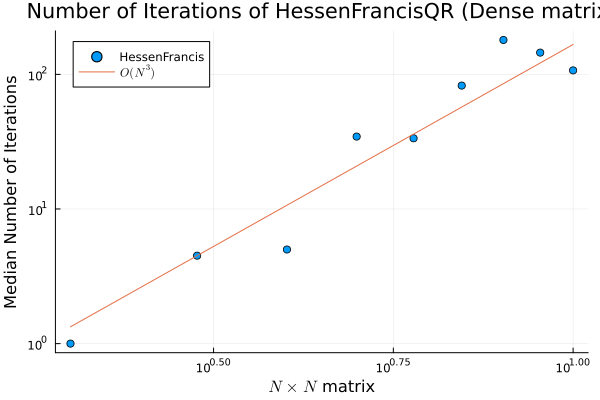

In [14]:
using LaTeXStrings
using Plots
plot(o,iterations,seriestype=:scatter,xaxis=:log10,yaxis=:log10,label="HessenFrancis")
xlabel!(L"$N\times N$ matrix")
ylabel!("Median Number of Iterations")
complexity =@. iterations[2]*o^3/o[2]^3
plot!(o,complexity,label=L"O(N^3)")
title!("Number of Iterations of HessenFrancisQR (Dense matrix)")
plot!(legend=:topleft)

In [4]:
itersanalysis(10)

Full matrix with maximum iterations:
10×10 Matrix{Float64}:
 -0.609566   -0.610893  -0.460936     0.504597   -0.690828   0.357851   -0.751032  -0.296704   -0.561526    0.74686
  0.624957   -0.278286   0.00923159   0.235701   -0.964091   0.0556407  -0.858698  -0.119983    0.448546   -0.117
  0.229452   -0.709256  -0.758166     0.453004   -0.256152   0.290467   -0.816825   0.0638545   0.502938   -0.678174
 -0.803549    0.883159   0.654076     0.422862   -0.536084  -0.91063    -0.169439  -0.425601    0.635758   -0.831305
  0.0570279  -0.675518   0.803852    -0.668392    0.251215   0.729671   -0.645132  -0.65049    -0.564496    0.0647914
  0.530436    0.141797  -0.0944282   -0.990668   -0.565843  -0.129712    0.613581   0.162578   -0.606919    0.00858322
  0.993166    0.392571  -0.7541       0.686866    0.447396   0.363014    0.765377  -0.798146    0.432314    0.543097
  0.786123    0.964699  -0.131468     0.920311   -0.159262  -0.45974    -0.41976   -0.627758    0.0335756  -0.606604
  0.3

(Any[117, 6222, 106, 103, 208, 20132, 59, 124, 54, 102, 57, 676, 212, 152, 58, 1072, 134, 408, 53, 449], 1524.9, 129.0, 20132)